<a href="https://colab.research.google.com/github/Bunny825/age_gender_prediction_functional_model/blob/main/age_gender_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jangedoo/utkface-new")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: baladityasaichinni
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new


100%|██████████| 331M/331M [00:04<00:00, 81.5MB/s]


In [ ]:
import os
folder="/content/utkface-new/UTKFace"
age=[]
gender=[]
image=[]

for i in os.listdir(folder):
  age.append(int(i.split("_")[0]))
  gender.append(int(i.split("_")[1]))
  image.append(i)

len(age)

23708

In [ ]:
import pandas as pd
df=pd.DataFrame({"age":age,"gender":gender,"image":image})
df.shape

(23708, 3)

In [ ]:
df.head()

,age,gender,image
0,28,1,28_1_4_20170117202546775.jpg.chip.jpg
1,24,1,24_1_2_20170116173417614.jpg.chip.jpg
2,26,0,26_0_3_20170119180602948.jpg.chip.jpg
3,46,0,46_0_3_20170119175317994.jpg.chip.jpg
4,50,0,50_0_2_20170116163531048.jpg.chip.jpg


In [ ]:
train_ds=df.sample(frac=1,random_state=0).iloc[:20000]
test_ds=df.sample(frac=1,random_state=0).iloc[20000:]

print(train_ds.shape)
print(test_ds.shape)

(20000, 3)
(3708, 3)


In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

train_datagen=ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    rescale=1/255,
    rotation_range=40,
    horizontal_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2
)

test_datagen=ImageDataGenerator(
    rescale=1/255
)

train_ds['gender'] = train_ds['gender'].astype(float)
test_ds['gender'] = test_ds['gender'].astype(float)


train = train_datagen.flow_from_dataframe(
    train_ds,
    target_size=(256,256),
    directory=folder,
    x_col='image',
    y_col=['age','gender'],
    class_mode="raw"
)

test = test_datagen.flow_from_dataframe(
    test_ds,
    target_size=(256,256),
    directory=folder,
    x_col='image',
    y_col=['age','gender'],
    class_mode="raw"
)





Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [ ]:
conv_base=VGG16(weights="imagenet",include_top=False,input_shape=(256,256,3))
conv_base.trainable=False
output=conv_base.layers[-1].output
flatten=Flatten()(output)
dense1=Dense(512,activation="relu")(flatten)
dense2=Dense(512,activation="relu")(flatten)

dense3=Dense(512,activation="relu")(dense1)
dense4=Dense(512,activation="relu")(dense2)

out1=Dense(1,activation="linear",name="age")(dense3)
out2=Dense(1,activation="sigmoid",name="gender")(dense4)

model=Model(inputs=conv_base.input,outputs=[out1,out2])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 48,796,482 (186.14 MB)

 Trainable params: 34,081,794 (130.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

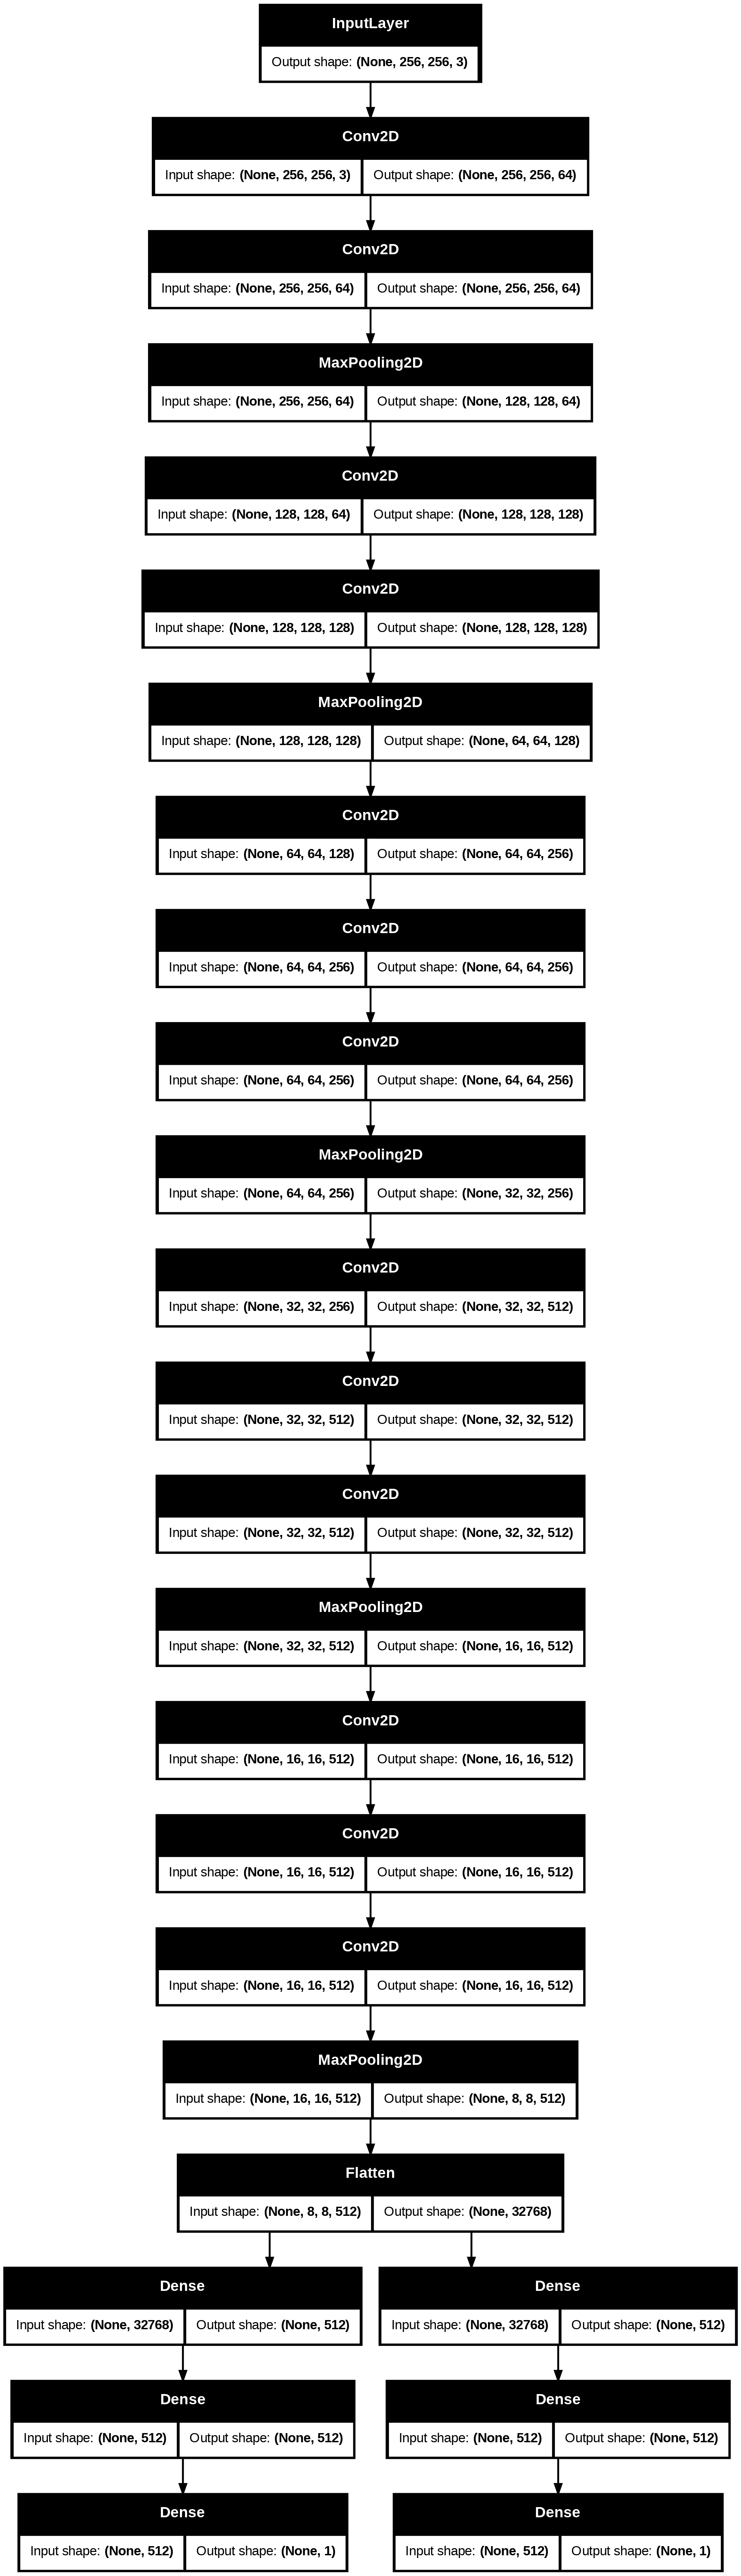

In [ ]:
from keras.utils import plot_model

plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer="adam",loss={"age":"mae","gender":"binary_crossentropy"},metrics={"age":"mae","gender":"accuracy"},loss_weights={"age":1,"gender":99})
model.fit(
    train,
    validation_data=test,
    epochs=10,
    steps_per_epoch=len(train),
    validation_steps=len(test)
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 71/625 ━━━━━━━━━━━━━━━━━━━━ 4:08:17 27s/step - age_mae: 18.2810 - loss: 18.2810